In [1]:
import sys
import re
import os
import pandas as pd
sys.path.append("../automaterialsdata/")

from chemdataextractor_parsers import NumericalProperty, OPVPropertyParser
from chemdataextractor_parsers import OPVMaterials, OPVMaterialsParser
from chemdataextractor_parsers import sentence_preprocessing

from chemdataextractor import Document
from chemdataextractor.model import Compound,ListType, ModelType
from chemdataextractor.doc import Paragraph, Sentence

Compound.opv_materials = ListType(ModelType(OPVMaterials))
Compound.opv_property = ListType(ModelType(NumericalProperty))
Sentence.parsers.append(OPVMaterialsParser())
Paragraph.parsers.append(OPVMaterialsParser())
Sentence.parsers.append(OPVPropertyParser())
Paragraph.parsers.append(OPVPropertyParser())

In [2]:
saeki_papers_path = "/Users/hanghu/Desktop/msedatapipeline/JPCL2018-papers_notPDF/no_table_found/"
saeki_papers = [x for x in os.listdir(saeki_papers_path) if x.endswith('xml') or x.endswith('html') ]
saeki_papers = sorted(saeki_papers, key=lambda x: int(re.match(r'[0-9]+', x)[0]))

saeki_papers[:10]

['15.html',
 '30.html',
 '34.html',
 '77.html',
 '92.html',
 '110.html',
 '154.html',
 '200.html',
 '204.html',
 '205.html']

In [3]:
def create_empty_opv_property_dataframe():
    colnames = ["Paper", "Material", "Property", "Value", "Unit"]
    return pd.DataFrame(columns=colnames)

def count_record_fields(r):
    counter = {'opv_materials': 0, 'opv_property': 0}
    for entry in r:
        entry_name = list(entry.keys())[0]
        counter[entry_name] += 1
        
    return counter['opv_materials'], counter['opv_property']

def check_record_row(row):
    if (row[2] == 'FF' and 1 < float(row[3]) < 100):
        row[3] = str(float(row[3]) / 100)
        
    if (row[2] == 'PCE' or row[2] == 'FF') and float(row[3]) > 100:
        return False
    
    return True 

In [4]:
def merge_records_to_dataframe(article_id, records):
    output_df = create_empty_opv_property_dataframe()
    colnames = list(output_df.columns)
    rows = set() 
    for r in records:
        material   = 'unknown'
        properties = []
        for entry in r:
            if 'opv_materials' in entry.keys():
                material = entry['opv_materials'][0]['name']
            else:
                property_i = entry['opv_property'][0]
                property_i['name'] = OPVPropertyParser.find_unique_name(property_i['name'])
                properties.append([property_i['name'], property_i['value'], property_i.get('unit', 'N/A')])

        for p in properties:
            p_row = [article_id, material] + p
            if check_record_row(p_row):
                rows.add(tuple(p_row))
    
    # remove duplicate value with unknown materials
    duplicate_rows = set()
    for r in rows:
        if r[1] != 'unknown':
            exam_r = list(r)
            exam_r[1] = 'unknown'
            exam_r = tuple(exam_r)
            if exam_r in rows:
                duplicate_rows.add(exam_r)
    
    for dr in duplicate_rows:
        rows.remove(dr)
    
    for r in rows:
        temp_df = pd.DataFrame(data=[list(r)], columns=colnames)
        output_df = pd.concat([output_df, temp_df], ignore_index=True)


    return output_df

In [5]:
output_df = create_empty_opv_property_dataframe()

for article in saeki_papers:
    print('* parsing ', article)
    f = open(os.path.join(saeki_papers_path, article), 'rb') #Extracting pdf article from One Compound folder
    try:
        doc = Document.from_file(f) 
    except:
        print("can't read")
        continue
    para = doc.elements # Outputs list of paragaph objects
    sentence_records = []
    for p in para: # stores all sentences from paragraphs
        if type(p) != Paragraph: continue
        i = 0
        useprev  = False
        while i < len(p):
            s = sentence_preprocessing(p[i])
            if useprev: s = sentence_preprocessing(p[i-1]) + s
            r = s.records.serialize()
            nMat, nP = count_record_fields(r)
            
            if nMat > 1 or nP == 0 or (nMat == 0 and nP == 0):
                i += 1
                useprev = False
            elif (nMat == 1 and nP > 0):
                sentence_records.append(r)
                i += 1
                useprev = False
            else:
                if (not useprev):
                    useprev = True
                    continue
                sentence_records.append(r)
                i += 1
                useprev = False
    temp_df = merge_records_to_dataframe(article, sentence_records)
    output_df = pd.concat([output_df, temp_df], ignore_index=True)
    
    print(' ... obtained ', len(temp_df), " records, total number of records now is ", len(output_df))
    
#output_df.to_csv("../data/saeki_first_full_output_.csv")

* parsing  15.html
 ... obtained  17  records, total number of records now is  17
* parsing  30.html
 ... obtained  4  records, total number of records now is  21
* parsing  34.html
 ... obtained  10  records, total number of records now is  31
* parsing  77.html
 ... obtained  5  records, total number of records now is  36
* parsing  92.html
 ... obtained  4  records, total number of records now is  40
* parsing  110.html
 ... obtained  3  records, total number of records now is  43
* parsing  154.html
 ... obtained  18  records, total number of records now is  61
* parsing  200.html
 ... obtained  5  records, total number of records now is  66
* parsing  204.html
 ... obtained  7  records, total number of records now is  73
* parsing  205.html
 ... obtained  4  records, total number of records now is  77
* parsing  241.html
 ... obtained  0  records, total number of records now is  77
* parsing  262.html
 ... obtained  3  records, total number of records now is  80
* parsing  271.htm

In [7]:
len(output_df[output_df['Material'] != 'unknown'])

119

In [8]:
len(output_df)

189

In [9]:
output_df.to_csv('../data/CDE_XML_HTML_Results.csv',encoding='utf-8')

# Accuracy of CDE

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from property_comparison import OPV_PROPERTIES, EXAM_TYPE, compare_properties

In [11]:
data_path = '../data/CDE_XML_HTML_Results.csv'
data = pd.read_csv(data_path, encoding="UTF-8")

saeki_path = '../../Saekis_manual_dataset.csv'
saeki_cols = ['ID No.','Nickname', 'Ref. No', 'PCE_max', 'PCE_ave', 'Voc', 'Jsc', 'FF']
saeki = pd.read_csv(saeki_path, encoding="UTF-8", usecols=saeki_cols)

In [12]:
#Clean NAs and non-numbers from property values

data[["Value"]] = data[["Value"]].apply(pd.to_numeric)
data.dropna(subset = ["Value"], inplace=True)


In [13]:
data['Paper'].unique()

array(['15.html', '30.html', '34.html', '77.html', '92.html', '110.html',
       '154.html', '200.html', '204.html', '205.html', '262.html',
       '271.html', '273.html', '289.html', '303.html', '309.html',
       '330.html', '333.html', '334.html', '346.html', '367.html',
       '368.html', '436.html'], dtype=object)

In [14]:
colnames  = ['Ref. No']

for p in OPV_PROPERTIES:
    for eT in EXAM_TYPE:
        colnames.append('_'.join([p,eT]))

comp_result = pd.DataFrame(columns=colnames)

In [15]:
saeki_cols = ['PCE_max', 'Voc', 'Jsc', 'FF']
errors = [0.2, 0.02, 0.5, 0.01]

for paper in data['Paper'].unique():
    print("Compare Results from ", paper)
    paper_id = int(paper.split('.')[0])
    tmp_result = [paper_id]
    
    saeki_result = saeki[saeki['Ref. No'] == 'S'+ str(paper_id)]
    saeki_compounds = set(saeki_result['Nickname'])
    
    cdr_result = data[data['Paper'] == paper]
    cdr_compounds = set(cdr_result['Material'])
    
    for p, sp, e in zip(OPV_PROPERTIES, saeki_cols, errors):
        
        print(p)
        
        cdr_records   = list(cdr_result[cdr_result['Property'] == p][['Material', 'Value']].to_records(index=False))
        saeki_records = list(saeki_result[['Nickname', sp]].to_records(index=False))
        print('CDR: ', cdr_records)
        print('SAEKI: ', saeki_records)
        results = compare_properties(cdr_records, saeki_records, e)
        print(results)
        tmp_result += results

    temp_df = pd.DataFrame(data=[tmp_result], columns=colnames)
    comp_result = pd.concat([comp_result, temp_df], ignore_index=True)

Compare Results from  15.html
PCE
CDR:  [('unknown', 0.6), ('P3HT', 0.39), ('P3HT:PDI(1:4)device', 0.19), ('unknown', 3.2), ('PCBM', 0.63), ('P3HT:PDI(1:4)device', 0.4), ('unknown', 0.04), ('unknown', 1.95)]
SAEKI:  [('PCz', 0.07)]
[1, 7, 0, 0, 0, 8, 1]
VOC
CDR:  [('P3HT:PDI(1:4)device', 0.4), ('PCBM', 0.71), ('unknown', 0.7)]
SAEKI:  [('PCz', 0.71)]
[1, 2, 0, 0, 0, 3, 1]
JSC
CDR:  [('unknown', 6.7), ('PCBM', 0.26), ('P3HT:PDI(1:4)device', 0.12)]
SAEKI:  [('PCz', 0.26)]
[1, 2, 0, 0, 0, 3, 1]
FF
CDR:  [('unknown', 0.43), ('PCBM', 0.37), ('P3HT:PDI(1:4)device', 0.39)]
SAEKI:  [('PCz', 0.37)]
[1, 2, 0, 0, 0, 3, 1]
Compare Results from  30.html
PCE
CDR:  [('PCTDPP', 2.27), ('PCPDTBT/PC71BM', 5.5), ('PCTDPP', 10.87), ('PCBM', 6.6)]
SAEKI:  [('PCTDPP', 2.27)]
[1, 3, 0, 1, 1, 2, 0]
VOC
CDR:  []
SAEKI:  [('PCTDPP', 0.47)]
[0, 0, 1, 0, 0, 0, 1]
JSC
CDR:  []
SAEKI:  [('PCTDPP', 10.87)]
[0, 0, 1, 0, 0, 0, 1]
FF
CDR:  []
SAEKI:  [('PCTDPP', 0.45)]
[0, 0, 1, 0, 0, 0, 1]
Compare Results from  34.htm

CDR:  [('PC71BM', 4.57)]
SAEKI:  [('CPDT-co-TPADCN', 4.45), ('CPDT-co-TPADTA', 4.65), ('CPDT-co-TPATCN', 1.26), ('CPDT-co-FADCN', 3.51), ('CPDT-co-FADTA', 4.57), ('CPDT-co-FATCN', 1.17)]
[1, 0, 5, 0, 0, 1, 6]
FF
CDR:  [('PC71BM', 0.43)]
SAEKI:  [('CPDT-co-TPADCN', 0.4), ('CPDT-co-TPADTA', 0.41), ('CPDT-co-TPATCN', 0.32), ('CPDT-co-FADCN', 0.49), ('CPDT-co-FADTA', 0.43), ('CPDT-co-FATCN', 0.38)]
[1, 0, 5, 0, 0, 1, 6]
Compare Results from  436.html
PCE
CDR:  []
SAEKI:  [('PDFBC-DPP', 7.33)]
[0, 0, 1, 0, 0, 0, 1]
VOC
CDR:  []
SAEKI:  [('PDFBC-DPP', 0.8)]
[0, 0, 1, 0, 0, 0, 1]
JSC
CDR:  []
SAEKI:  [('PDFBC-DPP', 13.15)]
[0, 0, 1, 0, 0, 0, 1]
FF
CDR:  [('PDFBC-DPP:PC61BM', 0.68)]
SAEKI:  [('PDFBC-DPP', 0.68)]
[1, 0, 0, 0, 0, 1, 1]


/Users/hanghu/Desktop/msedatapipeline/AutoMaterialsData-clean/notebooks/../automaterialsdata/property_comparison.py:59: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  idx = saeki_result.index((c,r))


In [16]:
sum_results = comp_result.sum()
sum_df = pd.DataFrame(data=[], columns=['Property', 'Exam_type', 'Count'])

for p in OPV_PROPERTIES:
    for eT in EXAM_TYPE[:3]:
        col = '_'.join([p,eT])
        tmp_result = [p, eT, sum_results[col]]
        temp_df = pd.DataFrame(data=[tmp_result], columns=['Property', 'Exam_type', 'Count'])
        sum_df = pd.concat([sum_df, temp_df], ignore_index=True)

sum_df

,Property,Exam_type,Count
0,PCE,value_only_TP,28
1,PCE,value_only_FN,52
2,PCE,value_only_Miss,9
3,VOC,value_only_TP,23
4,VOC,value_only_FN,17
5,VOC,value_only_Miss,14
6,JSC,value_only_TP,21
7,JSC,value_only_FN,15
8,JSC,value_only_Miss,16
9,FF,value_only_TP,24


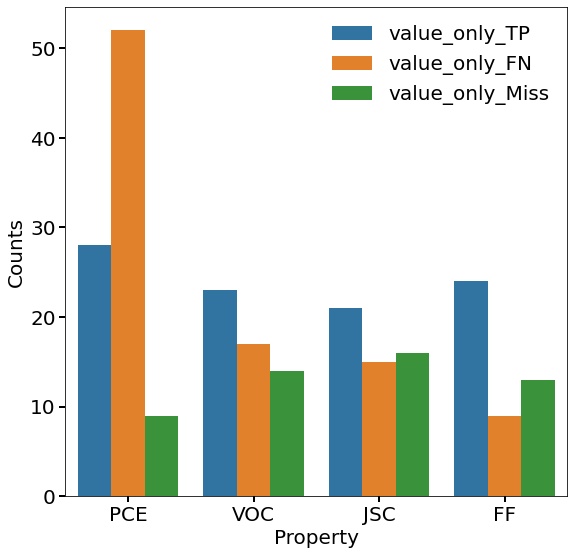

In [17]:
fig,ax = plt.subplots(figsize=(9,9))

sns.barplot(x="Property", y="Count", hue="Exam_type", data=sum_df, ax=ax)

ax.set_xlabel('Property', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)
ax.tick_params(direction='out', length=6, width=2, labelsize=20)
ax.legend(frameon=False, fontsize=20)

fig.savefig('./chemdataextractor_result_2.png', bbox_inches='tight') 

<AxesSubplot:xlabel='Property', ylabel='Count'>

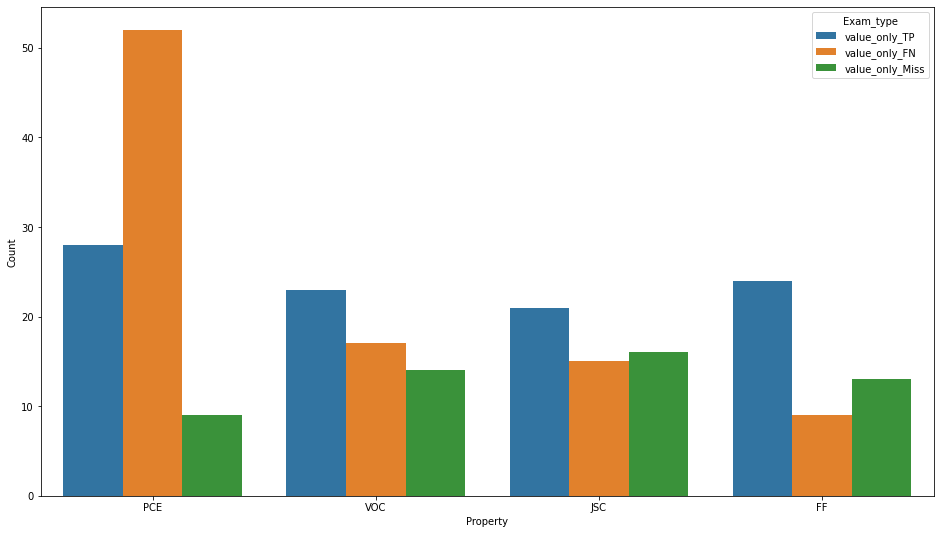

In [17]:
fig,ax = plt.subplots(figsize=(16,9))
sns.barplot(x="Property", y="Count", hue="Exam_type", data=sum_df, ax=ax)